In [17]:
import sys
sys.path.append('/home/jxm3/research/deidentification/unsupervised-deidentification')

from datamodule import WikipediaDataModule
from model import AbstractModel, CoordinateAscentModel
from utils import get_profile_embeddings_by_model_key

import argparse
import collections
import glob
import json
import os
import re

import datasets
import pandas as pd
import torch
import transformers
from tqdm import tqdm


from model_cfg import model_paths_dict

datasets.utils.logging.set_verbosity_error()


num_cpus = len(os.sched_getaffinity(0))


def get_profile_embeddings(model_key: str):
    profile_embeddings = get_profile_embeddings_by_model_key(model_key=model_key)

    print("concatenating train, val, and test profile embeddings")
    all_profile_embeddings = torch.cat(
        (profile_embeddings['test'], profile_embeddings['val'], profile_embeddings['train']), dim=0
    )

    print("all_profile_embeddings:", all_profile_embeddings.shape)
    return all_profile_embeddings

def load_adv_csv(dm: WikipediaDataModule, max_num_samples: int = 100) -> pd.DataFrame:
    # Load adv CSVs
    adv_df = None
    adv_csvs_folder = os.path.normpath(
        os.path.join(
            os.getcwd(), os.pardir, 'adv_csvs_full_8'
        )
    )
    print('adv_csvs_folder', adv_csvs_folder)
    model_csv_filenames = list(glob.glob(
        os.path.join(
            adv_csvs_folder,
            'model*/results*.csv'
        )
    ) )
    print("len(model_csv_filenames) =", len(model_csv_filenames))
    for filename in (model_csv_filenames):
        # print('filename:', filename)
        df = pd.read_csv(filename)
        
        if len(df) < 50: continue
        if "nomodel" in filename: continue
        if "k_None" in filename: continue
        if "k_0" in filename: continue
        print(filename)
        
        df = df[(df['result_type'] == 'Successful') | (df['result_type'] == 'Skipped')]
        json_filename = filename.replace('.csv', '__args.json')
        assert os.path.exists(json_filename)
        
        adv_csv_json = json.load(open(json_filename, 'r'))
        
        df["filename"] = filename
        for key, val in adv_csv_json.items():
            df[key] = val
        df["i"] = df.index
        
        df = df.rename(columns={"model": "model_name"})

        mini_df = df.iloc[:max_num_samples]

        if adv_df is None:
            adv_df = mini_df
        else:
            adv_df = pd.concat((adv_df, mini_df), axis=0)
        # print(adv_df)
    
    # Load baseline redacted data
    mini_test_dataset = dm.test_dataset[:max_num_samples]
    doc_df = pd.DataFrame(
        columns=['perturbed_text'],
        data=mini_test_dataset['document']
    )
    doc_df['model_name'] = 'document'
    doc_df['i'] = doc_df.index
    doc_df['filename'] = 'document'
    
    ner_df = pd.DataFrame(
        columns=['perturbed_text'],
        data=mini_test_dataset['document_redact_ner_bert']
    )
    ner_df['model_name'] = 'named_entity'
    ner_df['i'] = ner_df.index
    ner_df['filename'] = 'named_entity'
        
    lex_df = pd.DataFrame(
        columns=['perturbed_text'],
        data=mini_test_dataset['document_redact_lexical']
    )
    lex_df['model_name'] = 'lexical'
    lex_df['i'] = lex_df.index
    lex_df = lex_df.iloc[:max_num_samples]
    lex_df['filename'] = 'lexical'

    # Combine both adversarial and baseline redacted data
    baseline_df = pd.concat((doc_df, lex_df, ner_df), axis=0)
    for key in adv_csv_json.keys():
        if key not in baseline_df: baseline_df[key] = None
        
    
    full_df = pd.concat((adv_df, baseline_df), axis=0)
    
    # Put newlines back
    full_df['perturbed_text'] = full_df['perturbed_text'].apply(lambda s: s.replace('<SPLIT>', '\n'))

    # Standardize mask tokens
    full_df['perturbed_text'] = full_df['perturbed_text'].apply(lambda s: s.replace('[MASK]', dm.mask_token))
    full_df['perturbed_text'] = full_df['perturbed_text'].apply(lambda s: s.replace('<mask>', dm.mask_token))
    
    # Fair truncation
    full_df['original_num_words'] = full_df['perturbed_text'].map(lambda s: len(s.split()))
    for i in full_df['i'].unique():
        #         df.loc[df.loc[df['a'] == 1,'b'].index[1], 'b'] = 3
        min_num_words = full_df[full_df['i'] == i]['original_num_words'].min()
        full_df.loc[full_df[full_df['i'] == i].index, 'perturbed_text'] = (
            full_df.loc[full_df[full_df['i'] == i].index, 'perturbed_text'].map(
                lambda t: ' '.join(t.split()[:min_num_words])
            )
        )
    
    full_df['num_words'] = full_df['perturbed_text'].map(lambda s: len(s.split()))
    
    
    # This makes sure sure all documents with a given index have the same number of words.
    assert full_df.groupby('i')['num_words'].std().max() == 0.0

    return full_df


def get_adv_predictions(model_key: str, max_num_samples: int):
    checkpoint_path = model_paths_dict[model_key]
    assert isinstance(checkpoint_path, str), f"invalid checkpoint_path {checkpoint_path} for {model_key}"
    print(f"running eval on {model_key} loaded from {checkpoint_path}")
    model = CoordinateAscentModel.load_from_checkpoint(
        checkpoint_path
    )

    print(f"loading data with {num_cpus} CPUs")
    dm = WikipediaDataModule(
        document_model_name_or_path=model.document_model_name_or_path,
        profile_model_name_or_path=model.profile_model_name_or_path,
        dataset_name='wiki_bio',
        dataset_train_split='train[:256]',
        dataset_val_split='val[:256]',
        dataset_test_split='test[:100%]',
        dataset_version='1.2.0',
        num_workers=num_cpus,
        train_batch_size=256,
        eval_batch_size=256,
        max_seq_length=128,
        sample_spans=False,
    )
    dm.setup("fit")

    adv_csv = load_adv_csv(dm=dm, max_num_samples=max_num_samples)

    all_profile_embeddings = get_profile_embeddings(model_key=model_key).cuda()

    model.document_model.eval()
    model.document_model.cuda()
    model.document_embed.eval()
    model.document_embed.cuda()

    topk_values = []
    topk_idxs = []
    true_prof_confidences = []
    batch_size = 256
    i = 0
    while i < len(adv_csv):
        ex = adv_csv.iloc[i:i+batch_size]
        test_batch = dm.document_tokenizer.batch_encode_plus(
            ex['perturbed_text'].tolist(),
            max_length=dm.max_seq_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt',
        )
        test_batch = {
            f'perturbed_text__{k}': v for k,v in test_batch.items()
        }
        correct_idxs = torch.tensor(ex['i'].tolist()).cuda()
        with torch.no_grad():
            document_embeddings = model.forward_document(batch=test_batch, document_type='perturbed_text')
            document_to_profile_logits = document_embeddings @ all_profile_embeddings.T
            document_to_profile_probs = document_to_profile_logits.softmax(dim=1)
            topk_10 = document_to_profile_probs.topk(10)
            topk_values.append(topk_10.values)
            topk_idxs.append(topk_10.indices)
            true_prof_confidences.append(document_to_profile_probs[torch.arange(len(document_to_profile_probs)).cuda(), correct_idxs])

        i += batch_size
    
    adv_csv['pred_topk_values'] = torch.cat(topk_values, dim=0).cpu().tolist()
    adv_csv['pred_topk_idxs'] = torch.cat(topk_idxs, dim=0).cpu().tolist()
    adv_csv['true_prof_confidences'] = torch.cat(true_prof_confidences, dim=0).cpu().tolist()
    print('returning adv CSV')
    return adv_csv



In [19]:
n = 200

roberta_tapas_predictions = get_adv_predictions(model_key='model_3_2', max_num_samples=n)
roberta_roberta_predictions = get_adv_predictions(model_key='model_3_3', max_num_samples=n)
# pmlm_tapas_predictions = get_adv_predictions(model_key='model_3_4', max_num_samples=n)
# TODO: drop predictions if we predicted the same thing with same hparams just different values of n. Like
# if we have filenames with n=1000 and n=100. Just take the one with largest n.

running eval on model_3_2 loaded from /home/jxm3/research/deidentification/unsupervised-deidentification/saves/ca__roberta__tapas__dropout_-1.0_1.0_0.0__e3072__ls0.1/deid-wikibio-4_lightning_logs/ojgxa1tf_6/checkpoints/epoch=65-step=150282-idf_total.ckpt


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Initialized model with learning_rate = 0.0001 and patience 6
loading data with 8 CPUs
Initializing WikipediaDataModule with num_workers = 8 and mask token `<mask>`
loading wiki_bio[1.2.0] split train[:256]
loading wiki_bio[1.2.0] split val[:256]
loading wiki_bio[1.2.0] split test[:100%]
                        adv_csvs_folder /home/jxm3/research/deidentification/unsupervised-deidentification/adv_csvs_full_8
len(model_csv_filenames) = 121
/home/jxm3/research/deidentification/unsupervised-deidentification/adv_csvs_full_8/model_3_4/results__b_2__ts10.0__idf0.0__mp0.95__k_1__n_200__type_swap.csv
/home/jxm3/research/deidentification/unsupervised-deidentification/adv_csvs_full_8/model_3_4/results__b_2__ts10.0__idf0.0__mp0.95__k_2__n_200__type_swap.csv
/home/jxm3/research/deidentification/unsupervised-deidentification/adv_csvs_full_8/model_3_4/results__b_2__ts10.0__idf0.0__mp0.95__k_3__n_200__type_swap.csv
/home/jxm3/research/deidentification/unsupervised-deidentification/adv_csvs_full_8/mode

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaMod

Initialized model with learning_rate = 0.0001 and patience 6
loading data with 8 CPUs
Initializing WikipediaDataModule with num_workers = 8 and mask token `<mask>`
loading wiki_bio[1.2.0] split train[:256]
loading wiki_bio[1.2.0] split val[:256]
loading wiki_bio[1.2.0] split test[:100%]
                        adv_csvs_folder /home/jxm3/research/deidentification/unsupervised-deidentification/adv_csvs_full_8
len(model_csv_filenames) = 121
/home/jxm3/research/deidentification/unsupervised-deidentification/adv_csvs_full_8/model_3_4/results__b_2__ts10.0__idf0.0__mp0.95__k_1__n_200__type_swap.csv
/home/jxm3/research/deidentification/unsupervised-deidentification/adv_csvs_full_8/model_3_4/results__b_2__ts10.0__idf0.0__mp0.95__k_2__n_200__type_swap.csv
/home/jxm3/research/deidentification/unsupervised-deidentification/adv_csvs_full_8/model_3_4/results__b_2__ts10.0__idf0.0__mp0.95__k_3__n_200__type_swap.csv
/home/jxm3/research/deidentification/unsupervised-deidentification/adv_csvs_full_8/mode

In [20]:
roberta_tapas__no_masking_predictions = get_adv_predictions(model_key='model_3_1', max_num_samples=n)

running eval on model_3_1 loaded from /home/jxm3/research/deidentification/unsupervised-deidentification/saves/ca__roberta__tapas__e3072__ls0.1/deid-wikibio-4_default/1tu650oe_747/checkpoints/epoch=63-step=145727-idf_total.ckpt


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Initialized model with learning_rate = 0.0001 and patience 6
loading data with 8 CPUs
Initializing WikipediaDataModule with num_workers = 8 and mask token `<mask>`
loading wiki_bio[1.2.0] split train[:256]
loading wiki_bio[1.2.0] split val[:256]
loading wiki_bio[1.2.0] split test[:100%]
                        adv_csvs_folder /home/jxm3/research/deidentification/unsupervised-deidentification/adv_csvs_full_8
len(model_csv_filenames) = 121
/home/jxm3/research/deidentification/unsupervised-deidentification/adv_csvs_full_8/model_3_4/results__b_2__ts10.0__idf0.0__mp0.95__k_1__n_200__type_swap.csv
/home/jxm3/research/deidentification/unsupervised-deidentification/adv_csvs_full_8/model_3_4/results__b_2__ts10.0__idf0.0__mp0.95__k_2__n_200__type_swap.csv
/home/jxm3/research/deidentification/unsupervised-deidentification/adv_csvs_full_8/model_3_4/results__b_2__ts10.0__idf0.0__mp0.95__k_3__n_200__type_swap.csv
/home/jxm3/research/deidentification/unsupervised-deidentification/adv_csvs_full_8/mode

In [22]:
new_model_name = {
    # 'model_3_1': 'roberta_tapas__no_masking',
    'model_3_2': 'roberta_tapas',
    'model_3_3': 'roberta_roberta',
    'model_3_4': 'pmlm_tapas',
}

roberta_roberta_predictions['model_name'] = roberta_roberta_predictions['model_name'].apply(lambda s: new_model_name.get(s, s))

out_df = roberta_roberta_predictions.rename(
    columns={'pred_topk_values': 'roberta_roberta__pred_topk_values', 'pred_topk_idxs': 'roberta_roberta__pred_topk_idxs'}
)


# out_df['pmlm_tapas__pred_topk_values'] = pmlm_tapas_predictions['pred_topk_values']
# out_df['pmlm_tapas__pred_topk_idxs'] = pmlm_tapas_predictions['pred_topk_idxs']
# out_df['pmlm_tapas__true_prof_confidences'] = pmlm_tapas_predictions['true_prof_confidences']

out_df['roberta_roberta__pred_topk_values'] = roberta_roberta_predictions['pred_topk_values']
out_df['roberta_roberta__pred_topk_idxs'] = roberta_roberta_predictions['pred_topk_idxs']
out_df['roberta_roberta__true_prof_confidences'] = roberta_roberta_predictions['true_prof_confidences']


out_df['roberta_tapas__pred_topk_values'] = roberta_tapas_predictions['pred_topk_values']
out_df['roberta_tapas__pred_topk_idxs'] = roberta_tapas_predictions['pred_topk_idxs']
out_df['roberta_tapas__true_prof_confidences'] = roberta_tapas_predictions['true_prof_confidences']


# out_df['pmlm_tapas__was_correct'] = out_df.apply(lambda row: row['i'] == row['pmlm_tapas__pred_topk_idxs'][0], axis=1)
out_df['roberta_roberta__was_correct'] = out_df.apply(lambda row: row['i'] == row['roberta_roberta__pred_topk_idxs'][0], axis=1)
out_df['roberta_tapas__was_correct'] = out_df.apply(lambda row: row['i'] == row['roberta_tapas__pred_topk_idxs'][0], axis=1)


# out_df = out_df.drop(columns=['level_0', 'index', 'Unnamed: 0'])
out_df.head()

,Unnamed: 0,original_person,original_text,perturbed_person,perturbed_text,original_score,perturbed_score,original_output,perturbed_output,ground_truth_output,...,num_words,roberta_roberta__pred_topk_values,roberta_roberta__pred_topk_idxs,true_prof_confidences,roberta_roberta__true_prof_confidences,roberta_tapas__pred_topk_values,roberta_tapas__pred_topk_idxs,roberta_tapas__true_prof_confidences,roberta_roberta__was_correct,roberta_tapas__was_correct
0,0.0,Lenny randle,"leonard shenoff randle ( born february 12 , 19...",Gary nolan,"leonard <mask> <mask> ( born <mask> <mask> , <...",-15.695010,0.965902,0.0,28386.0,0.0,...,43,"[0.28600117564201355, 0.04644535109400749, 0.0...","[267136, 716838, 0, 582500, 633973, 424610, 44...",0.034583,0.034583,"[0.5570555925369263, 0.10722795873880386, 0.08...","[0, 267136, 144197, 633973, 550177, 532648, 72...",0.557056,False,True
1,1.0,Philippe adnot,philippe adnot ( born 25 august 1945 in rhèges...,René revol,<mask> <mask> ( born <mask> august <mask> in r...,-14.942733,2.565164,1.0,59276.0,1.0,...,108,"[0.2637613117694855, 0.07309182733297348, 0.04...","[1, 104583, 622305, 222836, 252691, 76222, 569...",0.263761,0.263761,"[0.1862749457359314, 0.163312628865242, 0.1187...","[255263, 305245, 193135, 646267, 720544, 55467...",0.000141,True,False
2,2.0,Miroslav popov,miroslav popov ( born 14 june 1995 in dvůr krá...,Jordi carchano,<mask> <mask> ( born <mask> <mask> <mask> in <...,-17.340431,1.839520,2.0,132875.0,2.0,...,39,"[0.3049541413784027, 0.17161589860916138, 0.16...","[345192, 256174, 627576, 132875, 256811, 8198,...",0.003817,0.003817,"[0.09912227839231491, 0.08386485278606415, 0.0...","[663514, 132875, 256174, 45484, 8198, 411731, ...",0.009935,False,False
3,3.0,Jack reynolds,john `` jack '' reynolds ( 21 february 1869 --...,Joe reader,<mask> `` <mask> '' <mask> ( <mask> <mask> <ma...,-16.618208,1.963475,3.0,48005.0,3.0,...,91,"[0.18507273495197296, 0.15490667521953583, 0.1...","[243519, 3, 545743, 147513, 461731, 455518, 55...",0.154907,0.154907,"[0.14160378277301788, 0.022900575771927834, 0....","[3, 264250, 114950, 608039, 162413, 461731, 20...",0.141604,False,True
4,4.0,Akoo nana,"william ato ankrah , ( born 7th july 1979 ) be...",Wande coal,"<mask> <mask> <mask> , ( born 7th <mask> <mask...",-19.462780,0.621973,4.0,61124.0,4.0,...,47,"[0.40452897548675537, 0.350078284740448, 0.034...","[4, 445867, 390710, 396943, 254701, 135944, 37...",0.404529,0.404529,"[0.18587203323841095, 0.0844753235578537, 0.07...","[4, 102770, 396943, 520062, 254701, 276446, 64...",0.185872,True,True


In [24]:
out_df["k"].value_counts()

1     197
2     195
3     190
4     187
8     179
13    174
16    169
24    162
32    155
Name: k, dtype: int64

In [25]:
import seaborn as sns

sns.set()
sns.set_theme(context="paper", style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

<AxesSubplot:xlabel='k', ylabel='roberta_roberta__true_prof_confidences'>

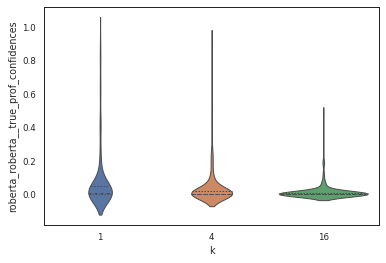

In [44]:
# TODO: Replace with Ridge PLot
# g = sns.FacetGrid(df, 

small_df = out_df[
    (out_df["k"] == 1) | (out_df["k"] == 4) | (out_df["k"] == 16)
]

# Violin plot
sns.violinplot(data=small_df, x="k", y="roberta_roberta__true_prof_confidences",
               split=True, inner="quart", linewidth=1,
)


In [54]:
import math
out_df["roberta_roberta__true_prof_confidences__log"] = out_df["roberta_roberta__true_prof_confidences"].map(lambda p: -1 * math.log(p))

/home/jxm3/.conda/envs/textattack/lib/python3.9/site-packages/seaborn/axisgrid.py:88: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/jxm3/.conda/envs/textattack/lib/python3.9/site-packages/seaborn/axisgrid.py:88: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/jxm3/.conda/envs/textattack/lib/python3.9/site-packages/seaborn/axisgrid.py:88: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/jxm3/.conda/envs/textattack/lib/python3.9/site-packages/seaborn/axisgrid.py:88: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.ti

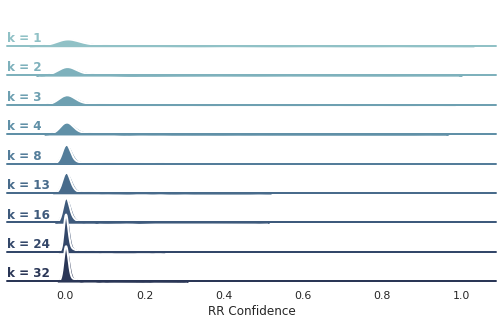

In [67]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

# Create the data
rs = np.random.RandomState(1979)
x = rs.randn(500)
g = np.tile(list("ABCDEFGHIJ"), 50)
df = pd.DataFrame(dict(x=x, g=g))
m = df.g.map(ord)
df["x"] += m

# Initialize the FacetGrid object
pal = sns.cubehelix_palette(10, rot=-.25, light=.7)
g = sns.FacetGrid(out_df, row="k", hue="k", aspect=15, height=.5, palette=pal)


y_key = "roberta_roberta__true_prof_confidences"

# Draw the densities in a few steps
g.map(sns.kdeplot, y_key,
      bw_adjust=.5, clip_on=False,
      fill=True, alpha=1, linewidth=1.5)
g.map(sns.kdeplot, y_key, clip_on=False, color="w", lw=2, bw_adjust=.45)

# passing color=None to refline() uses the hue mapping
g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)


# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, f"k = {label}", fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)


g.map(label, y_key)

# Set the subplots to overlap
g.figure.subplots_adjust(hspace=-.25)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[], ylabel="")
g.despine(bottom=True, left=True)

g.set(xlabel="RR Confidence")
# plt.title("RR confidence for RT deidentification across values of k")

/home/jxm3/.conda/envs/textattack/lib/python3.9/site-packages/seaborn/axisgrid.py:88: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/jxm3/.conda/envs/textattack/lib/python3.9/site-packages/seaborn/axisgrid.py:88: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/jxm3/.conda/envs/textattack/lib/python3.9/site-packages/seaborn/axisgrid.py:88: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/jxm3/.conda/envs/textattack/lib/python3.9/site-packages/seaborn/axisgrid.py:88: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.ti

['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_axes', '_axes_dict', '_bottom_axes', '_col_var', '_col_wrap', '_colors', '_dropna', '_extract_legend_handles', '_facet_color', '_facet_plot', '_figure', '_finalize_grid', '_get_palette', '_hue_var', '_inner_axes', '_left_axes', '_legend', '_legend_data', '_legend_out', '_margin_titles', '_margin_titles_texts', '_n_facets', '_ncol', '_not_bottom_axes', '_not_left_axes', '_not_na', '_nrow', '_row_var', '_tight_layout_pad', '_tight_layout_rect', '_update_legend_data', '_x_var', '_y_var', 'add_legend', 'ax', 'axes', 'axes_dict', 'col_names', 'data', 'despine', 'facet_axis', 'facet_data', 'fig', 'figure', 'hue_kws', 'hue_names', 'legend', 'map', 'map

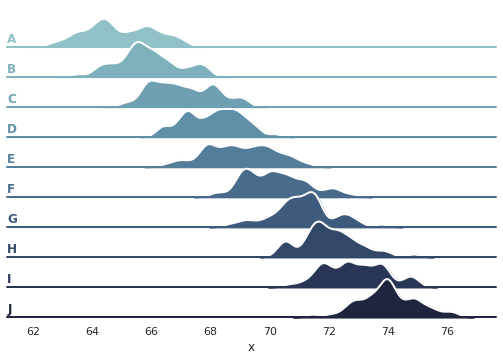

In [60]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

# Create the data
rs = np.random.RandomState(1979)
x = rs.randn(500)
g = np.tile(list("ABCDEFGHIJ"), 50)
df = pd.DataFrame(dict(x=x, g=g))
m = df.g.map(ord)
df["x"] += m

# Initialize the FacetGrid object
pal = sns.cubehelix_palette(10, rot=-.25, light=.7)
g = sns.FacetGrid(df, row="g", hue="g", aspect=15, height=.5, palette=pal)

# Draw the densities in a few steps
g.map(sns.kdeplot, "x",
      bw_adjust=.5, clip_on=False,
      fill=True, alpha=1, linewidth=1.5)
g.map(sns.kdeplot, "x", clip_on=False, color="w", lw=2, bw_adjust=.5)

# passing color=None to refline() uses the hue mapping
g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)


# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)


g.map(label, "x")

# Set the subplots to overlap
g.figure.subplots_adjust(hspace=-.25)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[], ylabel="")
g.despine(bottom=True, left=True)

print(dir(g))

<AxesSubplot:xlabel='k', ylabel='roberta_tapas__true_prof_confidences'>

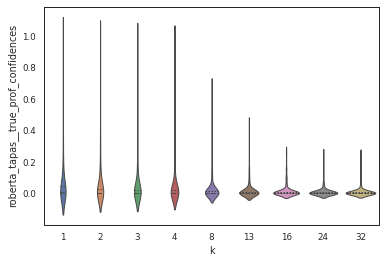

In [28]:
# TODO: Replace with Ridge PLot
# g = sns.FacetGrid(df, 

# Violin plot
sns.violinplot(data=out_df, x="k", y="roberta_tapas__true_prof_confidences",
               split=True, inner="quart", linewidth=1,
)


In [40]:
out_df.groupby("k").mean()[[c for c in out_df.columns if "was_correct" in c]]

,roberta_roberta__was_correct,roberta_tapas__was_correct
k,,
1,0.137056,0.172589
2,0.117949,0.143590
3,0.105263,0.115789
4,0.080214,0.096257
8,0.055866,0.061453
13,0.028736,0.040230
16,0.029586,0.029586
24,0.024691,0.030864
32,0.025806,0.019355
